In [2]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from plots import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [10]:
N = 300
K = 3
D = 2

## Model Parameters
SAMPLE_SIZE = 10
## Training Parameters
BATCH_SIZE = 20
CUDA = torch.cuda.is_available()
PATH = 'sanity-check-gibbs-z'

gpu = torch.device('cuda:0')

In [11]:
Xs = torch.from_numpy(np.load('rings_dataset/obs.npy')).float()
# STATES = torch.from_numpy(np.load('rings_dataset/states.npy')).float()
OBS_MU = torch.from_numpy(np.load('rings_dataset/obs_mu.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [15]:
prior_pi = torch.ones(K) * (1./ K)
if CUDA:
    prior_pi = prior_pi.cuda().to(gpu)
    
def enc_z(obs, obs_mu, radius, noise_sigma, sample_size, batch_size):
    obs_mu_expand = obs_mu.unsqueeze(-2).repeat(1, 1, 1, N, 1) # S * B * K * N * D
    obs_expand = obs.unsqueeze(2).repeat(1, 1, K, 1, 1) #  S * B * K * N * D
    distance = ((obs_expand - obs_mu_expand)**2).sum(-1).sqrt()
    obs_dist = Normal(torch.ones(1).cuda().to(gpu) * radius, torch.ones(1).cuda().to(gpu) * noise_sigma)
    log_distance = obs_dist.log_prob(distance).transpose(-1, -2) # S * B * N * K   

    q_pi = F.softmax(log_distance, -1)
    q = probtorch.Trace()
    p = probtorch.Trace()
    z = cat(q_pi).sample()
    _ = q.variable(cat, probs=q_pi, value=z, name='zs')
    p = probtorch.Trace()
    _ = p.variable(cat, probs=prior_pi, value=z, name='zs')
    return q, p

In [18]:
def Eubo(enc_z, obs, obs_mu, N, K, D, sample_size, batch_size, gpu):
    q_z, p_z = enc_z(obs, obs_mu, 1.5, 0.05, sample_size, batch_size)
    log_p_z = p_z['zs'].log_prob
    log_q_z = q_z['zs'].log_prob ## S * B * N
    states = q_z['zs'].value
    log_obs_n = Log_likelihood(obs, states, obs_mu, K, D, radius=1.5, noise_sigma = 0.05, gpu=gpu, cluster_flag=False)
    log_weights_local = log_obs_n + log_p_z - log_q_z
    weights_local = F.softmax(log_weights_local, 0).detach()

    eubo =(weights_local * log_weights_local).sum(0).sum(-1).mean()
    elbo = log_weights_local.mean()
    ess = (1. / (weights_local**2).sum(0)).mean()
    return eubo, elbo, ess, q_z

CPU times: user 4.63 s, sys: 21.3 ms, total: 4.65 s
Wall time: 4.65 s


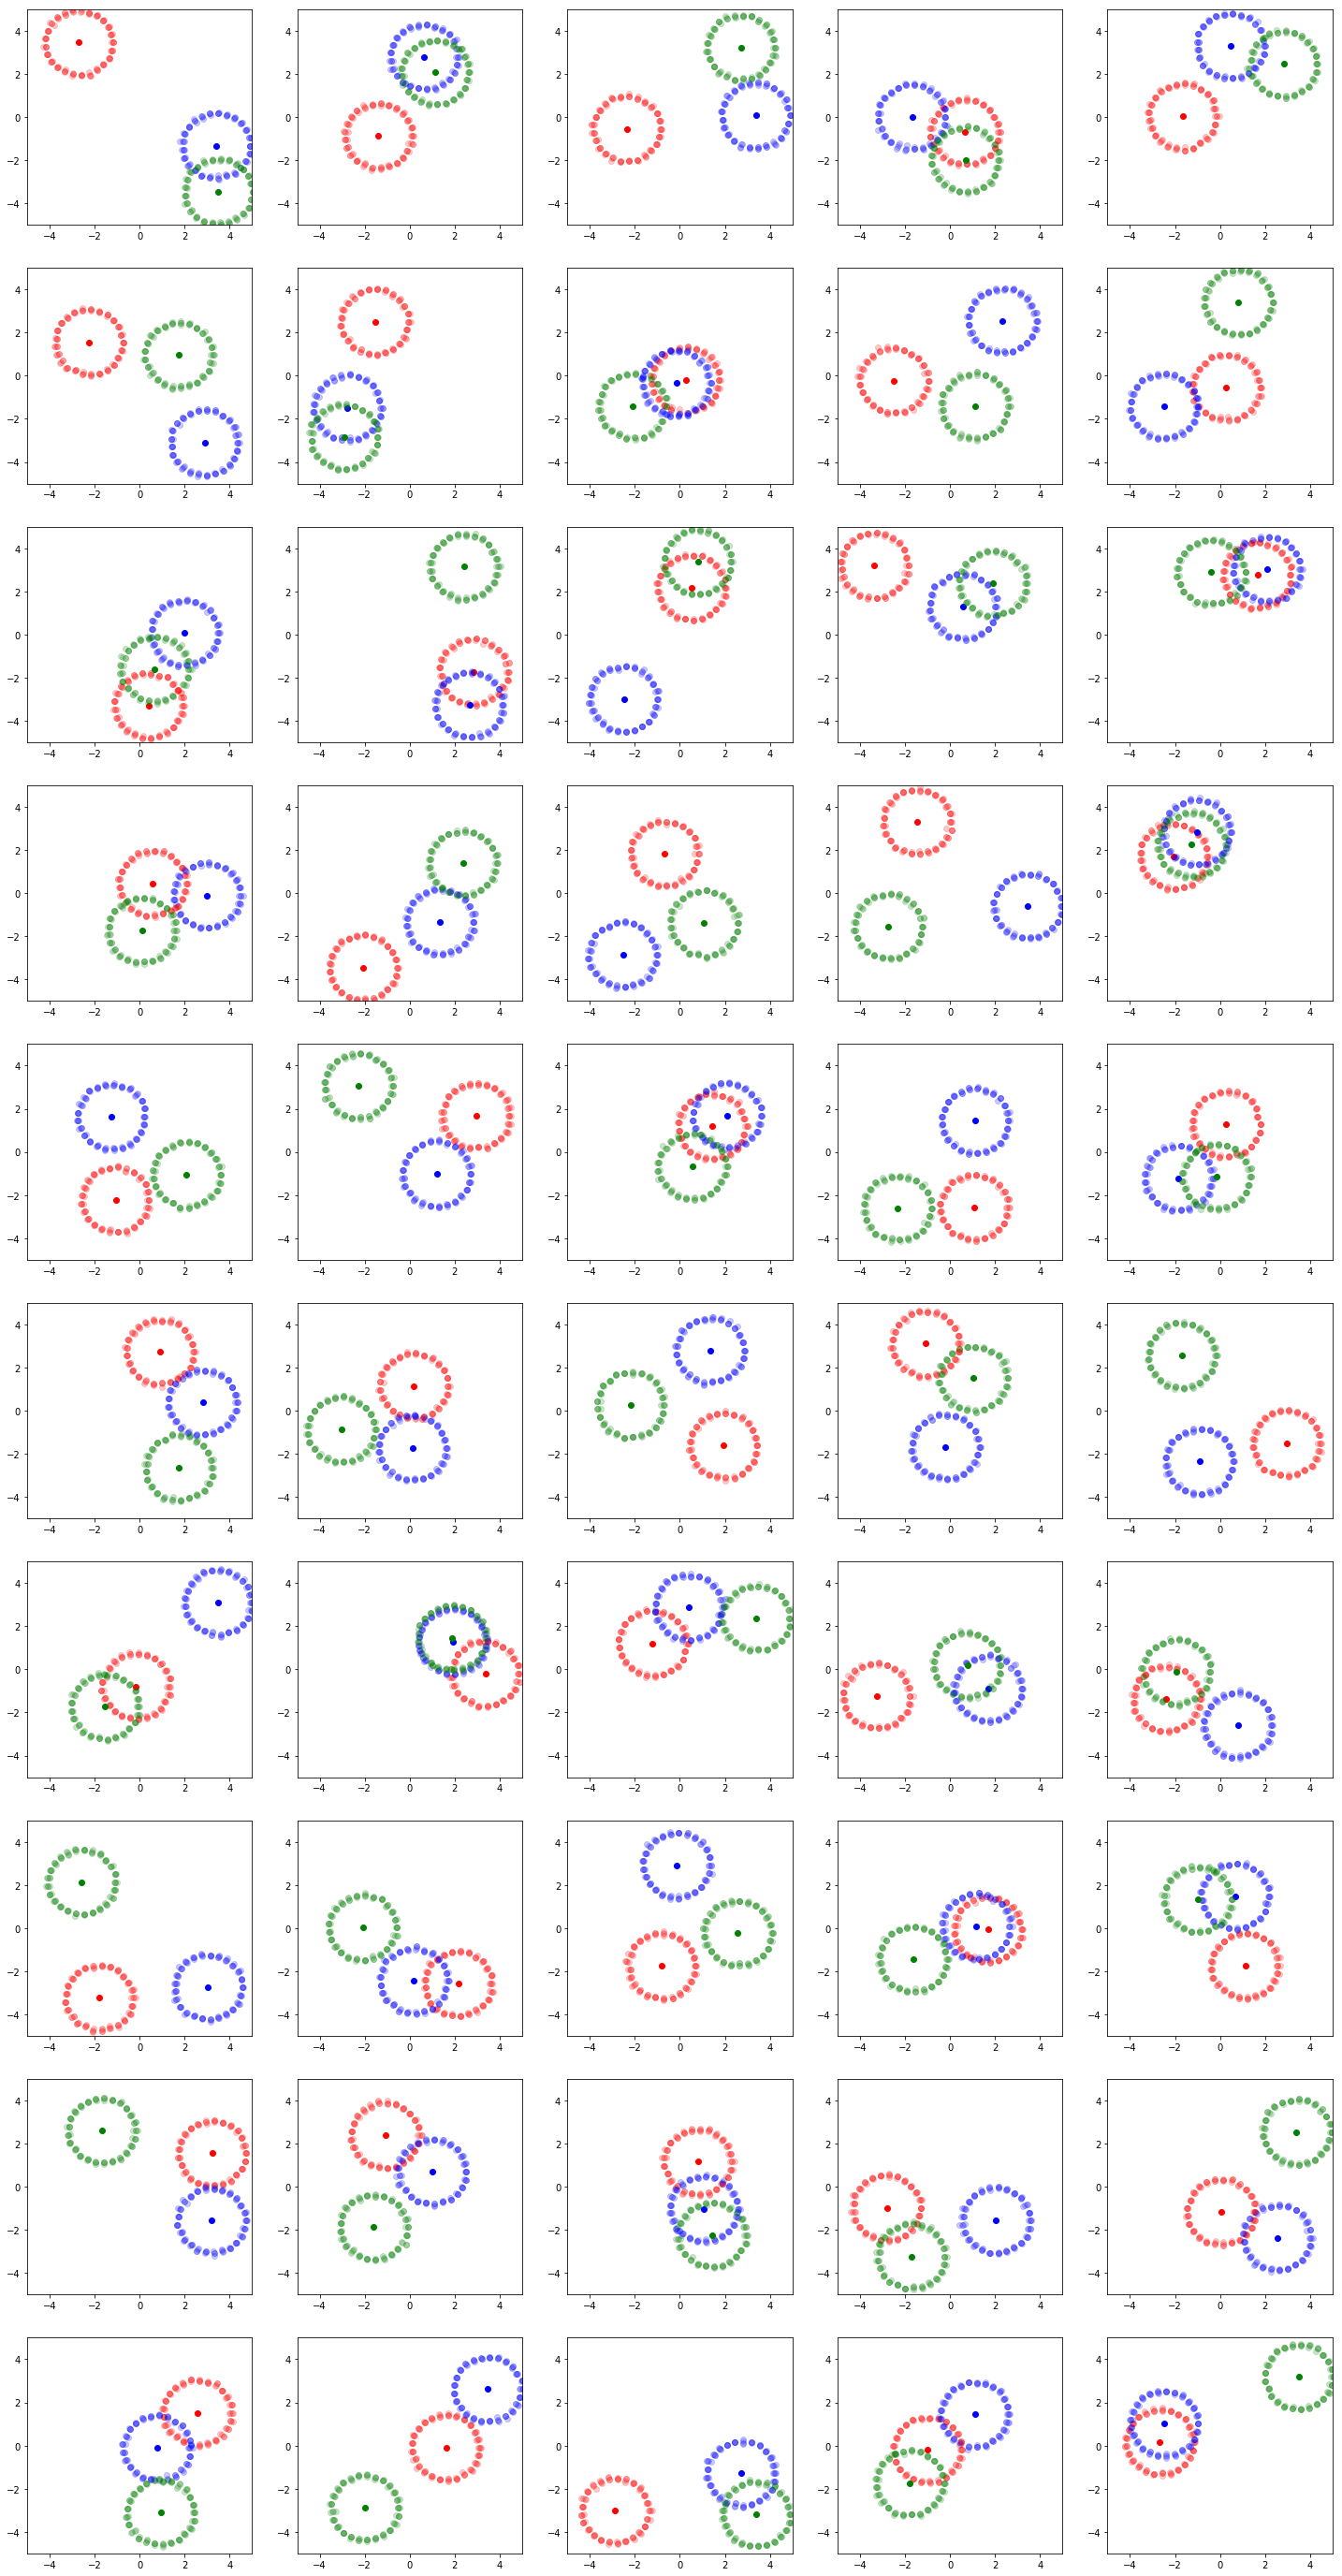

In [21]:
BATCH_SIZE_TEST = 50

def sample_single_batch(num_seqs, Xs, OBS_MU, sample_size, batch_size, gpu):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    obs_mu = OBS_MU[batch_indices].repeat(sample_size, 1, 1, 1)
    obs = shuffler(obs).repeat(sample_size, 1, 1, 1)
    if CUDA:
        obs = obs.cuda().to(gpu)
        obs_mu = obs_mu.cuda().to(gpu)
    return obs, obs_mu

def plot_samples(obs, q_eta, q_z, K, batch_size, PATH):
    colors = ['r', 'b', 'g']
    fig = plt.figure(figsize=(25,50))
    xs = obs[0].cpu().data.numpy()
    mu = obs_mu[0].cpu().data.numpy()
    zs = q_z['zs'].dist.probs[0].cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b]
        z = zs[b]
        mu_b = mu[b]
        assignments = z.argmax(-1)
        for k in range(K):
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
            ax.scatter(mu_b[k, 0], mu_b[k, 1], c=colors[k])
        ax.set_ylim([-5, 5])
        ax.set_xlim([-5, 5])
    plt.savefig('results/modes-' + PATH + '.svg')
    
obs, obs_mu = sample_single_batch(NUM_SEQS, Xs, OBS_MU, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
eubo, elbo, ess, q_z = Eubo(enc_z, obs, obs_mu, N, K, D, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
%time plot_samples(obs, obs_mu, q_z, K, BATCH_SIZE_TEST, PATH)

In [22]:
eubo

tensor(155.9884, device='cuda:0')

In [23]:
elbo

tensor(0.5200, device='cuda:0')